<a href="https://colab.research.google.com/github/GokayToga/VRCM.Net/blob/main/VRCMNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VRCM.Net**

Virtual Reality Cybersickness Mitigation&Prediction Net, this project is my research project on Exploration of Prediction and Reducement Techniques on Cybersickness in VR Technologies using Machine Learning and Deep Learning

In [ ]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Masking, TimeDistributed

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt


## Aproaches

Implement Semi-Supervised Pseudo-Labeling:

Use your base model to generate pseudo-labels for the unlabeled eye tracking dataset.

Combine the pseudo-labeled data with your original labeled data.

Retrain or fine-tune your model on the enriched dataset.


## Data

Gettint the 57 different files of cvs and 5 different volunteers with different parameters of data into one single complete cvs file


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Define the path to your CSV files
path = '/content/drive/MyDrive/490_Data'  # Replace with your actual path
all_files = glob.glob(os.path.join(path, "*.csv"))

# Initialize an empty list to hold individual DataFrames
df_list = []

# Iterate over each file
for file in all_files:
    # Extract the base filename without extension
    base_name = os.path.basename(file).replace('.csv', '')

    # Split the filename to extract metric type, volunteer ID, and movement type
    parts = base_name.split('_')
    metric_type = parts[0]
    volunteer_id = parts[1]
    movement_type = parts[2] if len(parts) > 2 else 'normal'  # Default to 'normal' if not specified

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)

    # Add new columns for volunteer ID, movement type, and metric type
    df['VolunteerID'] = volunteer_id
    df['MovementType'] = movement_type
    df['MetricType'] = metric_type

    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('/content/drive/MyDrive/combined_data.csv', index=False)


Gathering the data into Sessions

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("DATA_score&eye.csv")

# Optional: rename columns for consistency
df.rename(columns={
    'x_cordinate': 'x_coordinate',
    'y_cordinate': 'y_coordinate',
    'count' : 'Count'
}, inplace=True)

# Initialize session counter and list to hold session labels
session_counter = 1
session_labels = [f"S{session_counter}"]

# Iterate over rows starting from the second row
for i in range(1, len(df)):
    current_count = df.loc[i, 'Count']
    previous_count = df.loc[i - 1, 'Count']

    # If the current count is less than the previous count, assume a new session starts.
    # You can add a tolerance here if needed (e.g., a drop greater than 1 second).
    if current_count < previous_count:
        session_counter += 1
    session_labels.append(f"S{session_counter}")

# Add the session labels as a new column in the DataFrame
df['Session'] = session_labels

# Show the first few rows to verify the new column
print(df.head(20))

# Optionally, save the updated DataFrame to a new CSV
df.to_csv("DATA_score&eye_with_sessions.csv", index=False)


    Count  blink_count  avg_Left_Pupil  fixation_count  x_coordinate  \
0       5            3        1.709875               9     141.20950   
1      10            1        2.489131               9     136.88980   
2      15            3        2.365375              11     283.37930   
3      20            0        2.427528              10     178.37930   
4      25            1        2.685537               9     110.45930   
5      30            3        2.234481               9     234.58160   
6      35            1        2.429557               7     144.91930   
7      40            1        2.574318              12      40.19555   
8      45            1        2.671227               7     149.09990   
9      50            2        2.282701               5     133.52620   
10     55            1        2.368423               7     197.74960   
11     60            1        2.335357              11     170.96290   
12     65            3        2.651080               7       5.2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   count           1256 non-null   int64  
 1   blink_count     1256 non-null   int64  
 2   avg_Left_Pupil  1256 non-null   float64
 3   fixation_count  1256 non-null   int64  
 4   x_cordinate     1256 non-null   float64
 5   y_cordinate     1256 non-null   float64
 6   comfortLevel    1256 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 68.8 KB
None
             count  blink_count  avg_Left_Pupil  fixation_count   x_cordinate  \
count  1256.000000  1256.000000     1256.000000     1256.000000   1256.000000   
mean    131.349522     0.781847        2.933737       16.616242    425.876832   
std      79.461522     1.129195        0.765749       15.775795   2795.315881   
min       5.000000     0.000000        0.569626        1.000000 -98336.480000   
25%      70.000000     0.000

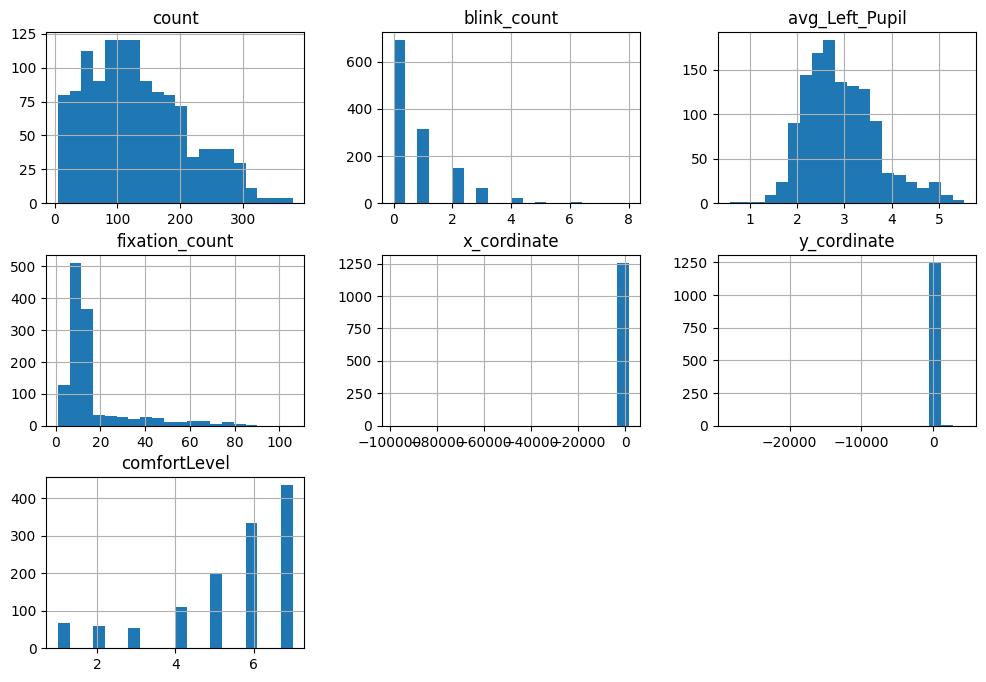

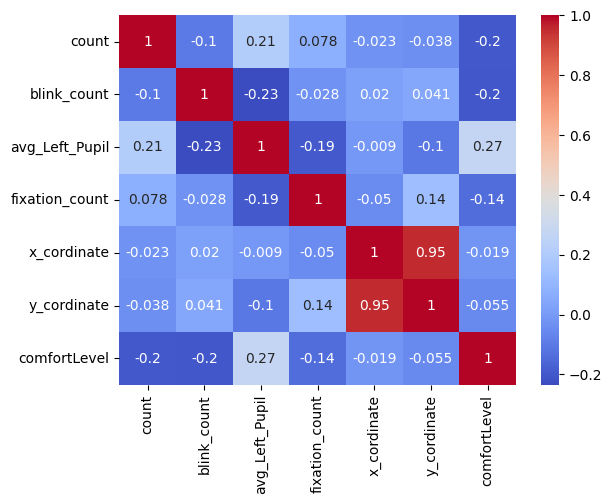

In [ ]:


# Load the new CSV data
data = pd.read_csv("DATA_score&eye.csv")


# Basic info and summary
print(data.info())
print(data.describe())

# Plot histograms of all features
data.hist(bins=20, figsize=(12, 8))
plt.show()

# Plot correlations between features and the target
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.show()


## Reinforcement Learning (Random Forests?)

Prediction of Cybersickness level

Explanation:

• This script loads the eye tracking dataset, trains a RandomForestRegressor (with hyperparameter tuning), evaluates its performance, and then converts the trained model into an ONNX model for Unity inference.

New training code for the complete cvs file with Cybersickness score

In [ ]:

# Define features and target
X = data[['count', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_cordinate', 'y_cordinate']]
y = data['comfortLevel']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Squared Error: 1.742865873015873
R² Score: 0.42949874795750587


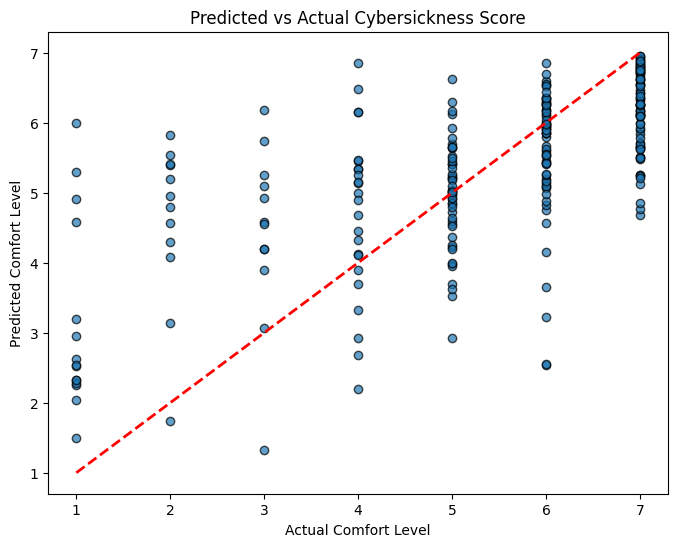

In [ ]:
# Predict on test data
y_pred = rf.predict(X_test)
# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k")
plt.xlabel("Actual Comfort Level")
plt.ylabel("Predicted Comfort Level")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicted vs Actual Cybersickness Score")
plt.show()

In [ ]:
import joblib
joblib.dump(rf, "rf_cybersickness_model.pkl")


['rf_cybersickness_model.pkl']

## RNN

In [ ]:

# Load the data
df = pd.read_csv("DATA_score&eye.csv")



# Define input features and sort by 'count' for sequence order
features = ['y_cordinate', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_cordinate']
df.sort_values(by='count', inplace=True)

# Group data by 'Count' if each count = a separate sequence (or treat count as timestep)
# For now, let’s assume your data is one long sequence split into fixed-length sequences
sequence_length = 10  # You can tune this
step = 1  # Slide by 1

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
comfort_level = df['comfortLevel'].values

# Create sequences
X_seq = []
y_seq = []
for i in range(0, len(scaled_features) - sequence_length, step):
    X_seq.append(scaled_features[i:i + sequence_length])
    y_seq.append(comfort_level[i + sequence_length - 1])  # Label at end of window

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)  # (samples, timesteps, features)
print("y_seq shape:", y_seq.shape)


X_seq shape: (1246, 10, 5)
y_seq shape: (1246,)


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Train
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 25.2927 - mae: 4.5969 - val_loss: 4.1606 - val_mae: 1.4060
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0337 - mae: 1.3280 - val_loss: 3.4752 - val_mae: 1.5251
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7917 - mae: 1.3491 - val_loss: 3.4382 - val_mae: 1.4611
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0173 - mae: 1.3976 - val_loss: 3.4266 - val_mae: 1.4555
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8786 - mae: 1.3561 - val_loss: 3.4130 - val_mae: 1.4090
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9784 - mae: 1.3473 - val_loss: 3.3299 - val_mae: 1.4097
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0058 - mae: 1.3981 - val_loss: 3.3023 - val_mae: 1.3891
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8097 - mae: 1.3039 - val_loss: 3.2004 - val_mae: 1.4098
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - l

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9519 - mae: 1.5544 
Test MSE: 3.74482798576355
Test MAE: 1.4891616106033325
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


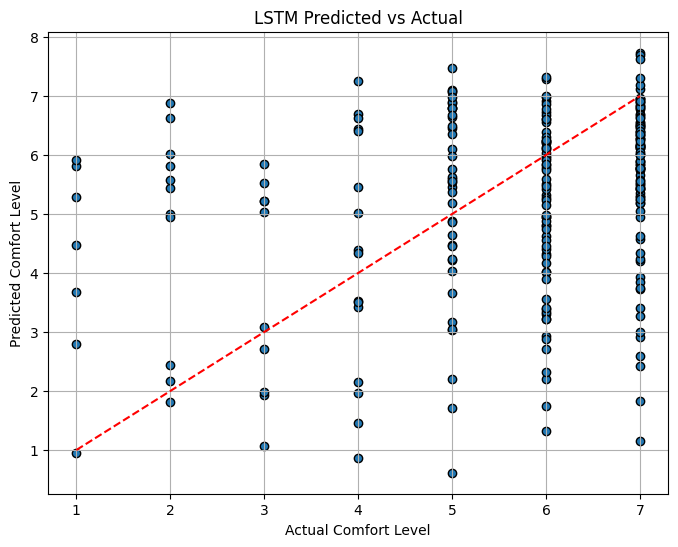

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print("Test MSE:", loss)
print("Test MAE:", mae)

# Optional: Predict and plot
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Comfort Level")
plt.ylabel("Predicted Comfort Level")
plt.title("LSTM Predicted vs Actual")
plt.grid(True)
plt.show()


## LSTM

#### Windowing

Grouping Data by Sessions

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file (with the session column added already)
df = pd.read_csv("DATA_score&eye_with_sessions.csv")

# Ensure data is sorted by Session and Count for each session
df = df.sort_values(by=['Session', 'Count'])

# List of unique sessions
sessions = df['Session'].unique()

# For each session, we’ll extract the feature array and target array
# Let’s define our feature columns and target column
feature_cols = ['y_coordinate', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_coordinate']
target_col = 'comfortLevel'

# Dictionary to store sequences for each session
session_sequences = []

# Minimum required sequence length (you may want to ignore sessions that are too short)
min_seq_length = 3  # For example, require at least 3 timesteps

for sess in sessions:
    sess_data = df[df['Session'] == sess]
    if len(sess_data) >= min_seq_length:
        # Extract features and target as numpy arrays (ordered by time)
        X_session = sess_data[feature_cols].values
        y_session = sess_data[target_col].values

        # Append as a tuple; you may decide whether to predict at each timestep or only the final timestep
        session_sequences.append((X_session, y_session))

print("Number of sessions extracted:", len(session_sequences))


Number of sessions extracted: 30


Fixing the lenght sequence

In [ ]:
def create_sequences(X, y, window_size=5, step=1):
    """
    Given a session's feature matrix X and target vector y,
    returns a list of sequences (X_seq, y_seq) where:
    - X_seq is shape (window_size, num_features)
    - y_seq is the target at the end of the window (or could be an average)
    """
    X_seqs = []
    y_seqs = []
    for i in range(0, len(X) - window_size + 1, step):
        X_seqs.append(X[i:i+window_size])
        y_seqs.append(y[i+window_size-1])  # Label as the final comfortLevel of the window
    return np.array(X_seqs), np.array(y_seqs)

# Collect sequences across all sessions
X_all, y_all = [], []

window_size = 10  # For instance, each sequence covers 5 timesteps (i.e., 25 seconds)
for X_session, y_session in session_sequences:
    if len(X_session) >= window_size:
        X_seq, y_seq = create_sequences(X_session, y_session, window_size=window_size)
        X_all.append(X_seq)
        y_all.append(y_seq)

# Combine sequences from all sessions
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print("Shape of X_all:", X_all.shape)  # (total_sequences, window_size, num_features)
print("Shape of y_all:", y_all.shape)


Shape of X_all: (986, 10, 5)
Shape of y_all: (986,)


LSTM

In [ ]:

# Define the LSTM model
num_features = X_all.shape[2]
model = Sequential([
    LSTM(64, input_shape=(window_size, num_features), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 10, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 26.5778 - mae: 4.8236 - val_loss: 9.6296 - val_mae: 2.8535
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.9430 - mae: 2.3104 - val_loss: 3.1592 - val_mae: 1.3040
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1576 - mae: 1.3929 - val_loss: 2.7904 - val_mae: 1.2892
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1217 - mae: 1.4331 - val_loss: 2.8730 - val_mae: 1.2177
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9182 - mae: 1.3408 - val_loss: 2.7185 - val_mae: 1.2435
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8252 - mae: 1.3209 - val_loss: 2.6069 - val_mae: 1.2082
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0195 - mae: 1.3228 - val_loss: 2.6524 - val_mae: 1.2018
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5802 - mae: 1.2469 - val_loss: 2.5797 - val_mae: 1.2248
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8649 - mae: 1.0589 
Test MSE: 1.8484327793121338
Test MAE: 1.0617748498916626
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


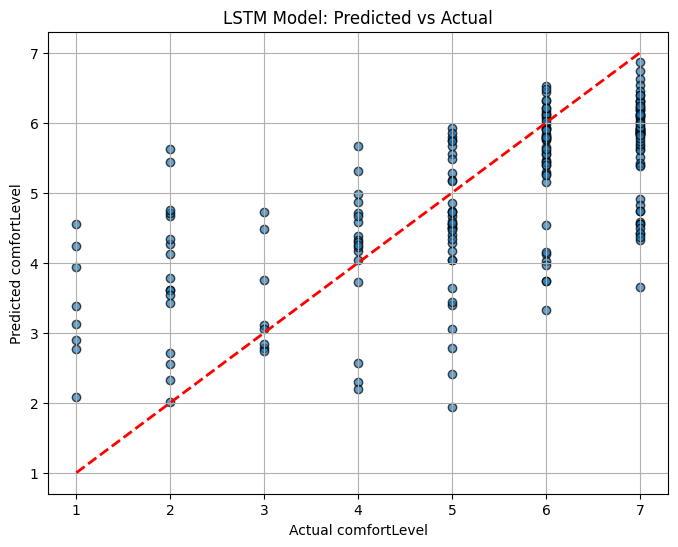

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print("Test MSE:", loss)
print("Test MAE:", mae)

# Predict on test set and visualize
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual comfortLevel")
plt.ylabel("Predicted comfortLevel")
plt.title("LSTM Model: Predicted vs Actual")
plt.grid(True)
plt.show()


In [ ]:
model.save("lstm_cybersickness_model.h5")


#### Padding

In [ ]:

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your CSV file (ensure it has the "Session" column and the necessary feature/target columns)
df = pd.read_csv("DATA_score&eye_with_sessions.csv")

# Define feature columns and target column
feature_cols = ['y_coordinate', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_coordinate']
target_col = 'comfortLevel'

# Ensure the data is sorted by session and time (e.g., 'Count' column)
df = df.sort_values(by=['Session', 'Count'])

# Group the data by session
session_groups = df.groupby("Session")
session_features = []
session_targets = []

for sess, group in session_groups:
    # Extract features and targets as numpy arrays
    X_session = group[feature_cols].values   # shape (timesteps, num_features)
    y_session = group[target_col].values       # shape (timesteps,)
    session_features.append(X_session)
    session_targets.append(y_session)

# Determine the maximum sequence length (or set a fixed maximum)
max_sequence_length = max(len(seq) for seq in session_features)
# Alternatively, set a fixed value (e.g., 60 for 300 seconds)
# max_sequence_length = 60

# Pad the sequences
X_padded = pad_sequences(session_features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
y_padded = pad_sequences(session_targets, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
# For regression, expand dims of y to (num_sessions, timesteps, 1)
y_padded = np.expand_dims(y_padded, -1)

print("X_padded shape:", X_padded.shape)  # (num_sessions, max_sequence_length, num_features)
print("y_padded shape:", y_padded.shape)  # (num_sessions, max_sequence_length, 1)


X_padded shape: (30, 76, 5)
y_padded shape: (30, 76, 1)


### Many-to-Many LSTM Model

In [ ]:

num_features = X_padded.shape[2]

model = Sequential([
    # Use a Masking layer to ignore padded timesteps (assumes padded value is 0.0)
    Masking(mask_value=0.0, input_shape=(max_sequence_length, num_features)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(16, activation='relu')),
    TimeDistributed(Dense(1, activation='linear'))  # Predict comfort level at each timestep
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='MeanSquaredError', metrics=['mae'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 76, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 76, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 76, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 76, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 76, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 76, 16)              │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 76, 1)               │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
tf.config.run_functions_eagerly(True)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)
# Example: if you pad with 0, create a mask for target != 0
weights = (y_padded != 0.0).astype(float)  # shape: (num_sessions, max_len, 1)
weights = np.squeeze(weights, axis=-1)     # shape: (num_sessions, max_len)

history = model.fit(X_train, y_train, sample_weight=weights, epochs=100, batch_size=16, validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 942ms/step - loss: 32.7087 - mae: 3.0071 - val_loss: 24.4519 - val_mae: 3.0221
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step - loss: 29.9191 - mae: 2.9151 - val_loss: 22.6980 - val_mae: 2.9012
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - loss: 27.3063 - mae: 2.7407 - val_loss: 21.1144 - val_mae: 2.7851
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - loss: 26.5373 - mae: 2.6535 - val_loss: 19.7990 - val_mae: 2.6830
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 24.6903 - mae: 2.5566 - val_loss: 18.6222 - val_mae: 2.5895
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - loss: 23.5507 - mae: 2.5158 - val_loss: 17.4614 - val_mae: 2.4966
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step - loss: 21.2258 - mae: 2.3763 - val_loss: 16.2447 - val_mae: 2.3990
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step - loss: 19.9187 - mae: 2.3180 - val_loss: 14.9368 - val_mae: 2.2895
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step 

In [ ]:
model.compile(optimizer="adam", loss="MeanSquaredError", metrics=["mae"])
model.save("/content/LSTM_cybersickness_model_v2.keras")


In [ ]:
model = load_model("/content/LSTM_cybersickness_model_v2.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 3.7582 - mae: 0.9711
Test MSE: 3.7582333087921143
Test MAE: 0.9711408615112305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


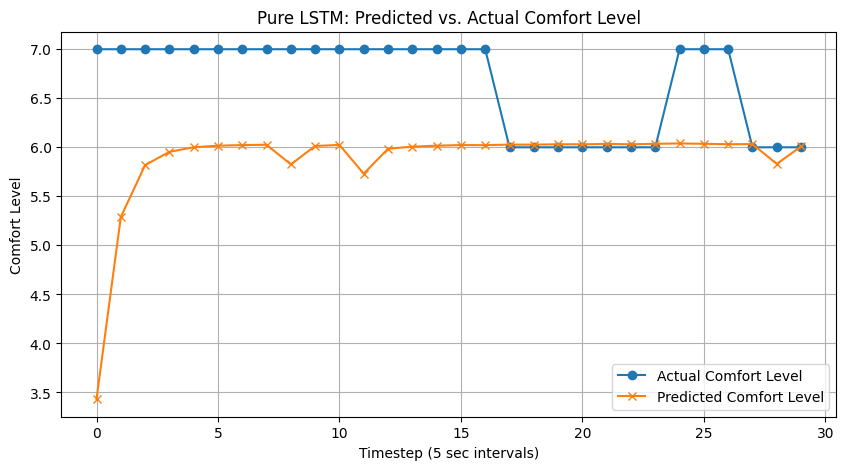

In [ ]:
loss, mae = model_gru.evaluate(X_test, y_test, sample_weight=weights_test.squeeze(-1))
print("Test MSE:", loss)
print("Test MAE:", mae)

import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Choose an example session from the test set
example_idx = 0
# Determine the actual length of the session from weights (non-zero entries indicate real data)
real_length = int((weights_test[example_idx].squeeze() > 0).sum())

# Extract only the real timesteps for plotting
y_true_example = y_test[example_idx].squeeze()[:real_length]
y_pred_example = y_pred[example_idx].squeeze()[:real_length]

plt.figure(figsize=(10, 5))
plt.plot(y_true_example, label="Actual Comfort Level", marker='o')
plt.plot(y_pred_example, label="Predicted Comfort Level", marker='x')
plt.xlabel("Timestep (5 sec intervals)")
plt.ylabel("Comfort Level")
plt.title("Pure LSTM: Predicted vs. Actual Comfort Level")
plt.legend()
plt.grid(True)
plt.show()



## CNN‐RNN Hybrid

### 1D CNN Front-End + GRU Back-End **(Chosen Model Architecture)**

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the CSV file (make sure the file path is correct)
df = pd.read_csv("DATA_score&eye_with_sessions.csv")

# Ensure the data is sorted by Session and then by Count (time order)
df = df.sort_values(by=['Session', 'Count'])

# Define the feature columns and target column
feature_cols = ['y_coordinate', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_coordinate']
target_col = 'comfortLevel'

# Group the data by session and extract sequences
session_features = []
session_targets = []
session_lengths = []  # to keep track of actual sequence lengths

for sess, group in df.groupby("Session"):
    group_sorted = group.sort_values(by='Count')
    X_session = group_sorted[feature_cols].values  # shape: (timesteps, num_features)
    y_session = group_sorted[target_col].values      # shape: (timesteps,)
    session_features.append(X_session)
    session_targets.append(y_session)
    session_lengths.append(len(y_session))

print("Total sessions found:", len(session_features))

# Decide on a maximum sequence length. You can use the maximum actual length or a fixed length.
max_sequence_length = max(session_lengths)  # or set a fixed value if you want truncation (e.g., 60)

# Pad the feature sequences. Padded values default to 0.0.
X_padded = pad_sequences(session_features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Pad the target sequences similarly.
y_padded = pad_sequences(session_targets, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
# For many-to-many regression, expand dims so that y has shape (num_sessions, timesteps, 1)
y_padded = np.expand_dims(y_padded, axis=-1)

print("X_padded shape:", X_padded.shape)  # (num_sessions, max_sequence_length, num_features)
print("y_padded shape:", y_padded.shape)  # (num_sessions, max_sequence_length, 1)

# Create a sample weight array that is 1.0 for real timesteps and 0.0 for padded ones.
# We assume that in your original data, comfortLevel is never 0 (so 0 indicates padding).
sample_weights = []
for seq in session_targets:
    weight_seq = np.ones(len(seq), dtype=np.float32)
    # Pad the weights to max_sequence_length with 0's
    padded_weights = np.pad(weight_seq, (0, max_sequence_length - len(seq)), mode='constant', constant_values=0)
    sample_weights.append(padded_weights)
sample_weights = np.array(sample_weights)  # shape: (num_sessions, max_sequence_length)

# Optionally, if you want sample_weights to have an extra dimension for TimeDistributed layers:
sample_weights = np.expand_dims(sample_weights, axis=-1)
print("Sample weights shape:", sample_weights.shape)


Total sessions found: 30
X_padded shape: (30, 76, 5)
y_padded shape: (30, 76, 1)
Sample weights shape: (30, 76, 1)


#### CNN + Bidirectinal GRU + Self Attention

In [ ]:
import numpy as np

# X_padded: (num_sessions, T, num_features)
# Compute deltas along the time axis
X_delta = np.zeros_like(X_padded)
X_delta[:,1:,:] = X_padded[:,1:,:] - X_padded[:,:-1,:]
# Concatenate so new feature dim = num_features * 2
X_enriched = np.concatenate([X_padded, X_delta], axis=-1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, BatchNormalization, Dropout,
    Bidirectional, GRU, MultiHeadAttention, Add, LayerNormalization,
    TimeDistributed, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Assume X_enriched with shape (num_sessions, T, D) is ready
T, D = X_enriched.shape[1], X_enriched.shape[2]

# 1) Input + Masking
inp = Input(shape=(T, D), name="input_sequence")
x = Masking(mask_value=0.0, name="masking")(inp)

# 2) CNN Front‑End
x = Conv1D(32, kernel_size=3, padding='same', activation='relu', name="conv1d")(x)
x = BatchNormalization(name="bn")(x)
x = Dropout(0.1, name="dropout_cnn")(x)

# 3) Bidirectional GRU Back‑End
x = Bidirectional(GRU(64, return_sequences=True), name="bigru_1")(x)
x = Dropout(0.2, name="dropout_gru1")(x)
x = Bidirectional(GRU(32, return_sequences=True), name="bigru_2")(x)
x = Dropout(0.2, name="dropout_gru2")(x)

# 4) Self‑Attention over the sequence
#    Query=Key=Value all = x
attn_output = MultiHeadAttention(num_heads=2, key_dim=32, name="mha")(query=x, value=x, key=x)
#  Add & Norm (residual)
x = Add(name="attn_residual")([x, attn_output])
x = LayerNormalization(name="attn_norm")(x)

# 5) TimeDistributed Output for per‑timestep regression
x = TimeDistributed(Dense(16, activation='relu'), name="td_dense")(x)
out = TimeDistributed(Dense(1, activation='linear'), name="td_output")(x)

model = Model(inputs=inp, outputs=out, name="cnn_bigru_attention")

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse',
    metrics=['mae']
)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "cnn_bigru_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 76, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 76, 10)    │          0 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 76, 32)    │        992 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn                  │ (None, 76, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_cnn         │ (None, 76, 32)    │          0 │ bn[0][0]          │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bigru_1             │ (None, 76, 128)   │     37,632 │ dropout_cnn[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru1        │ (None, 76, 128)   │          0 │ bigru_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bigru_2             │ (None, 76, 64)    │     31,104 │ dropout_gru1[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_gru2        │ (None, 76, 64)    │          0 │ bigru_2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 76, 64)    │     16,640 │ dropout_gru2[0][… │
│ (MultiHeadAttentio… │                   │            │ dropout_gru2[0][… │
│                     │                   │            │ dropout_gru2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_residual (Add) │ (None, 76, 64)    │          0 │ dropout_gru2[0][… │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_norm           │ (None, 76, 64)    │        128 │ attn_residual[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense            │ (None, 76, 16)    │      1,040 │ attn_norm[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_output           │ (None, 76, 1)     │         17 │ td_dense[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,681 (342.50 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# X_enriched: shape (num_sessions, T, 2*num_features)
# y_padded:   shape (num_sessions, T, 1)
# sample_weights: shape (num_sessions, T, 1)

X_train_enriched, X_test_enriched, y_train, y_test, w_train, w_test = train_test_split(
    X_enriched, y_padded, sample_weights,
    test_size=0.2, random_state=42
)

print(X_train_enriched.shape, y_train.shape, w_train.shape)
# e.g. (24, T, 2*D), (24, T, 1), (24, T, 1)


(24, 76, 10) (24, 76, 1) (24, 76, 1)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

history = model.fit(
    X_train_enriched, y_train,
    sample_weight=w_train.squeeze(-1),
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[es, rl]
)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 10.4585 - mae: 2.5308

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 10.1098 - mae: 2.4785 - val_loss: 5.6242 - val_mae: 2.2167 - learning_rate: 5.0000e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 5.3891 - mae: 1.9280 - val_loss: 2.7850 - val_mae: 1.7382 - learning_rate: 5.0000e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.9509 - mae: 1.5810 - val_loss: 1.9420 - val_mae: 1.5603 - learning_rate: 5.0000e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.1749 - mae: 1.4289 - val_loss: 2.0080 - val_mae: 1.5050 - learning_rate: 5.0000e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.7524 - mae: 1.2424 - val_loss: 2.3764 - val_mae: 1.5357 - learning_rate: 5.0000e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.7354 - mae: 1.2209 - val_loss: 2.7319 - val_mae: 1.5664 - learning_rate: 5.0000e-04
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.6001 - mae: 1.1247 - val_loss: 2.9628 - val_mae: 1.5872 - learning_rate: 5.0000e-04
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 2.1387 - mae: 1.4787
Test MSE: 2.1386632919311523 Test MAE: 1.4786659479141235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


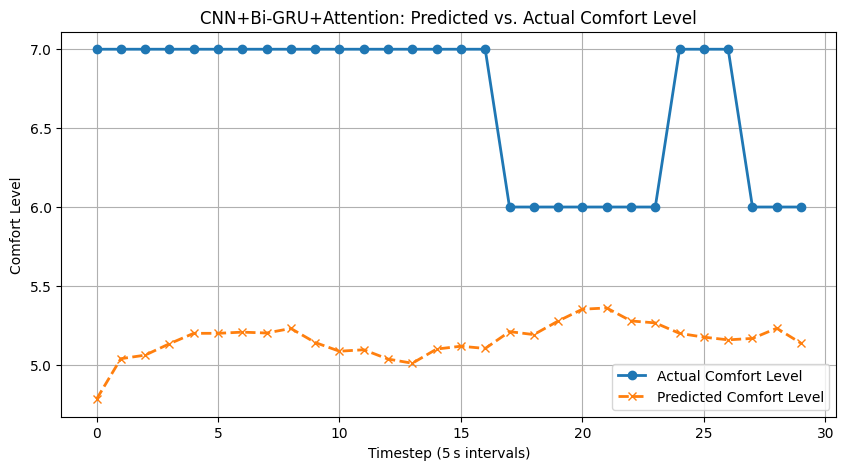

In [ ]:
loss, mae = model.evaluate(
    X_test_enriched,
    y_test,
    sample_weight = w_test.squeeze(-1)
)
print("Test MSE:", loss, "Test MAE:", mae)

import numpy as np
import matplotlib.pyplot as plt

# 1) Predict on the test set
y_pred = model.predict(X_test_enriched)  # shape: (num_test_sessions, T, 1)

# 2) Visualize predictions for one example session
example_idx = 0  # pick any index from 0 to num_test_sessions-1

# Compute the “real” length of that session by checking sample weights
# (non-zero entries correspond to actual data, zeros are padding)
real_length = int(np.sum(w_test[example_idx].squeeze() > 0))

# Extract only the valid timesteps
y_true_example = y_test[example_idx].squeeze()[:real_length]
y_pred_example = y_pred[example_idx].squeeze()[:real_length]

# 3) Plot
plt.figure(figsize=(10, 5))
plt.plot(
    np.arange(real_length),
    y_true_example,
    'o-',
    label="Actual Comfort Level",
    linewidth=2
)
plt.plot(
    np.arange(real_length),
    y_pred_example,
    'x--',
    label="Predicted Comfort Level",
    linewidth=2
)
plt.xlabel("Timestep (5 s intervals)")
plt.ylabel("Comfort Level")
plt.title("CNN+Bi‑GRU+Attention: Predicted vs. Actual Comfort Level")
plt.legend()
plt.grid(True)
plt.show()


#### 1D CNN Front-End + GRU Back-End

Fine tuned version

In [ ]:
# 1) Custom directional loss
def directional_loss(lambda_delta=0.1):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        dy_true = y_true[:, 1:, :] - y_true[:, :-1, :]
        dy_pred = y_pred[:, 1:, :] - y_pred[:, :-1, :]
        mse_delta = tf.reduce_mean(tf.square(dy_true - dy_pred))
        return mse_loss + lambda_delta * mse_delta
    return loss

# 1) Custom trend‐aware loss: MSE + hinge on derivative
def trend_loss(alpha=0.1):
    def loss(y_true, y_pred):
        # Mean Squared Error
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)  # shape (batch, timesteps)
        # First‐order differences
        dy_true = y_true[:,1:,:] - y_true[:,:-1,:]
        dy_pred = y_pred[:,1:,:] - y_pred[:,:-1,:]
        # Hinge penalizing wrong sign of derivative
        trend = -dy_true * dy_pred
        hinge = tf.maximum(0.0, trend)
        hinge_loss = tf.reduce_mean(hinge, axis=-1)  # shape (batch,)
        # Align dims: pad one timestep of zero
        hinge_loss = tf.pad(hinge_loss, [[0,0]], constant_values=0.0)
        return mse + alpha * hinge_loss
    return loss



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Conv1D, MaxPooling1D, GRU, Dropout, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

num_features = X_padded.shape[2]

model_gru = Sequential([
    Masking(mask_value=0.0, input_shape=(max_sequence_length, num_features)),
    Conv1D(filters=16, kernel_size=2, activation='relu', padding='same'),#try 64,128 for filters and for kernel 5,7 may adjust dropout
    MaxPooling1D(pool_size=2, strides=1, padding='same'),

    #GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    GRU(32, return_sequences=True, dropout=0.1),#maybe one more layer GRU or increase gru units
    GRU(16, return_sequences=True, dropout=0.1),

    TimeDistributed(Dense(16, activation='relu')),
    TimeDistributed(Dense(1, activation='linear'))
])

#model_gru.add(TimeDistributed(Dense(1, activation='linear')))
model_gru.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=directional_loss(0.1),
    metrics=['mae']
)
model_gru.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 76, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 76, 16)         │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 76, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 76, 32)         │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 76, 16)         │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 76, 16)         │           272 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 76, 1)          │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,665 (29.94 KB)

 Trainable params: 7,665 (29.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# 2) Build multi‐task TCN+GRU model
def build_trend_model(T, D, alpha=0.1):
    inp = Input(shape=(T, D), name='input')
    x = Masking(mask_value=0.0)(inp)
    # Temporal Convolutional Blocks (dilated causal conv)
    x = Conv1D(64, 5, padding='causal', dilation_rate=1, activation='relu')(x)
    x = Conv1D(64, 5, padding='causal', dilation_rate=2, activation='relu')(x)
    x = Conv1D(64, 5, padding='causal', dilation_rate=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    # Recurrent layers
    x = GRU(32, return_sequences=True, dropout=0.2)(x)
    x = GRU(16, return_sequences=True, dropout=0.15)(x)
    # Regression head: comfort score
    reg = TimeDistributed(Dense(1, activation='sigmoid'), name='comfort_raw')(x)
    reg_out = Lambda(lambda z: z * 7.0, name='comfort')(reg)
    # Classification head: up/down/flat
    cls_logits = TimeDistributed(Dense(3), name='trend_logits')(x)
    cls_out = TimeDistributed(Dense(3, activation='softmax'), name='trend_cls')(x)
    model = Model(inp, [reg_out, cls_out])
    model.compile(
        optimizer=Adam(1e-4),
        loss={
            'comfort': trend_loss(alpha),
            'trend_cls': 'categorical_crossentropy'
        },
        loss_weights={'comfort':1.0, 'trend_cls':0.5},
        metrics={'comfort':'mae', 'trend_cls':'accuracy'}
    )
    return model

# 3) Prepare classification labels from y_train/y_test
def make_trend_labels(y):
    # y: shape (N, T, 1)
    diff = y[:,1:,0] - y[:,:-1,0]  # shape (N, T-1)
    cls = np.zeros((y.shape[0], y.shape[1], 3), dtype='float32')
    # sign: -1 => down(0), 0=>flat(1), +1=>up(2)
    sign = np.sign(diff)
    for i in range(y.shape[0]):
        cls[i,0,1] = 1.0  # flat at the first timestep
        for t in range(1, y.shape[1]):
            s = sign[i,t-1]
            idx = 1 if s==0 else (2 if s>0 else 0)
            cls[i,t,idx] = 1.0
    return cls


In [ ]:

# Split session-wise (each session is one sample)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_padded, y_padded, sample_weights, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.model_selection import train_test_split

# Split session-wise (each session is one sample)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_padded, y_padded, sample_weights, test_size=0.2, random_state=42
)

#implement earlystopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#implement ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

history = model_gru.fit(
    X_train, y_train,
    epochs=150,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
        ],
    sample_weight=weights_train.squeeze(-1)  # sample_weight shape should match (num_samples, timesteps)
)


Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 10.0511 - mae: 3.0099 - val_loss: 10.1431 - val_mae: 3.0443 - learning_rate: 0.0010
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 9.7783 - mae: 2.9322 - val_loss: 9.5215 - val_mae: 2.9300 - learning_rate: 0.0010
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 9.0222 - mae: 2.8227 - val_loss: 9.4287 - val_mae: 2.9313 - learning_rate: 0.0010
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.6396 - mae: 2.7456 - val_loss: 9.0002 - val_mae: 2.8359 - learning_rate: 0.0010
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.4301 - mae: 2.7660 - val_loss: 8.6795 - val_mae: 2.7912 - learning_rate: 0.0010
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.9945 - mae: 2.6805 - val_loss: 7.9989 - val_mae: 2.6730 - learning_rate: 0.0010
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 6.6773 - mae: 2.4280 - val_loss: 7.4094 - val_mae: 2.5586 - learning_rate: 0.0010
Epoch 8/150
3/3 ━━━

In [ ]:
# 4) Instantiate and train
T, D = X_train_scaled.shape[1], X_train_scaled.shape[2]
model_trend = build_trend_model(T, D, alpha=0.1)
model_trend.summary()

# Create trend labels
y_train_cls = make_trend_labels(y_train)
y_test_cls  = make_trend_labels(y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 76, 5)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, 76, 5)     │          0 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 76, 64)    │      1,664 │ masking_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 76, 64)    │     20,544 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 76, 64)    │     20,544 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 76, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 76, 32)    │      9,408 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 76, 16)    │      2,400 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ comfort_raw         │ (None, 76, 1)     │         17 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ comfort (Lambda)    │ (None, 76, 1)     │          0 │ comfort_raw[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trend_cls           │ (None, 76, 3)     │         51 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,628 (213.39 KB)

 Trainable params: 54,628 (213.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(weights_train.shape)
print(y_train.shape)

(24, 76, 1)
(24, 76, 1)


In [ ]:
# Fix sample weight shapes
comfort_weights_train = weights_train.squeeze(-1)         # (batch, T)
trend_weights_train   = weights_train.squeeze(-1)         # (batch, T)

comfort_weights_test  = weights_test.squeeze(-1)          # (batch, T)
trend_weights_test    = weights_test.squeeze(-1)          # (batch, T)

sample_weight = {
    'comfort': weights_train.squeeze(-1),   # Shape: (24, 76)
    'trend_cls': weights_train.squeeze(-1)  # Shape: (24, 76)
}

validation_sample_weight = {
    'comfort': weights_test.squeeze(-1),   # Shape: (24, 76)
    'trend_cls': weights_test.squeeze(-1)  # Shape: (24, 76)
}



# Train the model
history = model_trend.fit(
    x = X_train_scaled,
    y = {'comfort':    y_train,
         'trend_cls':  y_train_cls},
    sample_weight = {
        'comfort':    comfort_weights_train,
        'trend_cls':  trend_weights_train
    },
    validation_data = (
        X_test_scaled,
        {'comfort':    y_test,
         'trend_cls':  y_test_cls},
        {
         'comfort':    comfort_weights_test,
         'trend_cls':  trend_weights_test
        }
    ),
    epochs=50,
    batch_size=8,
    callbacks=[
      EarlyStopping(monitor='val_comfort_mae', patience=8, restore_best_weights=True),
      ReduceLROnPlateau(monitor='val_comfort_loss', factor=0.5, patience=5, min_lr=1e-6)
    ],
    verbose=1
)


Epoch 1/50


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [ ]:
model_gru.save("/content/FT_CNN_GRU_Model_Psu.keras")

In [ ]:
model_gru = tf.keras.models.load_model("/content/FT_CNN_GRU_Model_Final.keras",
                                       custom_objects={'loss': directional_loss(lambda_delta=0.1)})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3452 - mae: 0.9495
Test MSE: 1.3451875448226929
Test MAE: 0.9495060443878174
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


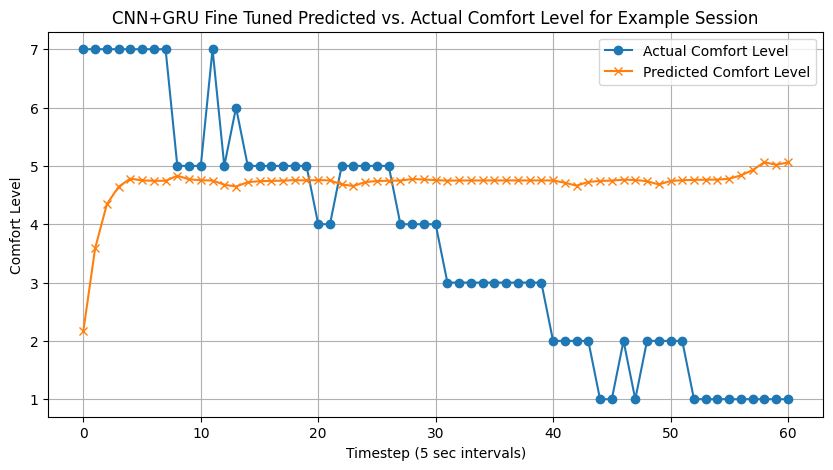

In [ ]:
loss, mae = model_gru.evaluate(X_test, y_test, sample_weight=weights_test.squeeze(-1))
print("Test MSE:", loss)
print("Test MAE:", mae)

# Predict on the test set
y_pred = model_gru.predict(X_test)

# Visualize predictions for one example session from the test set.
import matplotlib.pyplot as plt

# Choose an example session (e.g., first one)
example_idx = 1
# Determine the actual length of the session from weights: non-zero entries indicate real timesteps.
real_length = np.sum(weights_test[example_idx].squeeze() > 0)

# Extract the actual and predicted values for real timesteps only.
y_true_example = y_test[example_idx].squeeze()[:int(real_length)]
y_pred_example = y_pred[example_idx].squeeze()[:int(real_length)]

plt.figure(figsize=(10, 5))
plt.plot(y_true_example, label="Actual Comfort Level", marker='o')
plt.plot(y_pred_example, label="Predicted Comfort Level", marker='x')
plt.xlabel("Timestep (5 sec intervals)")
plt.ylabel("Comfort Level")
plt.title("CNN+GRU Fine Tuned Predicted vs. Actual Comfort Level for Example Session")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3101 - mae: 0.9336
Test MSE: 1.3101085424423218
Test MAE: 0.9335639476776123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


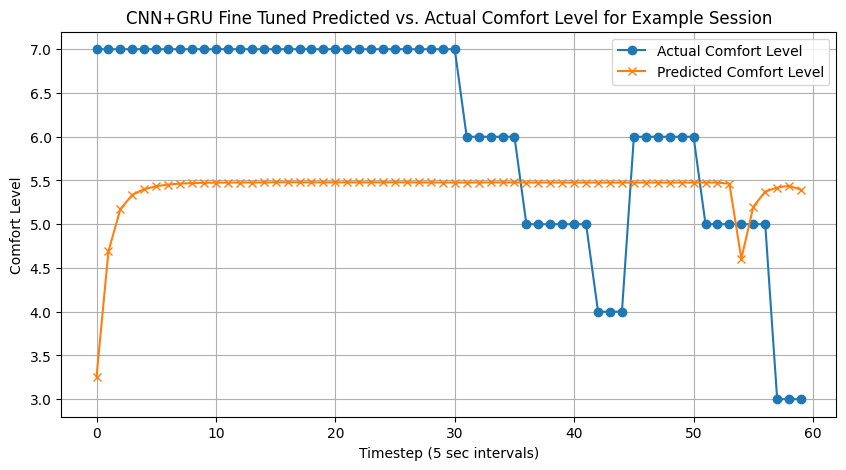

In [ ]:
loss, mae = model_gru.evaluate(X_test, y_test, sample_weight=weights_test.squeeze(-1))
print("Test MSE:", loss)
print("Test MAE:", mae)

# Predict on the test set
y_pred = model_gru.predict(X_test)

# Visualize predictions for one example session from the test set.
import matplotlib.pyplot as plt

# Choose an example session (e.g., first one)
example_idx = 2

# Determine the actual length of the session from weights: non-zero entries indicate real timesteps.
real_length = np.sum(weights_test[example_idx].squeeze() > 0)

# Extract the actual and predicted values for real timesteps only.
y_true_example = y_test[example_idx].squeeze()[:int(real_length)]
y_pred_example = y_pred[example_idx].squeeze()[:int(real_length)]

plt.figure(figsize=(10, 5))
plt.plot(y_true_example, label="Actual Comfort Level", marker='o')
plt.plot(y_pred_example, label="Predicted Comfort Level", marker='x')
plt.xlabel("Timestep (5 sec intervals)")
plt.ylabel("Comfort Level")
plt.title("CNN+GRU Fine Tuned Predicted vs. Actual Comfort Level for Example Session")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 5) Evaluate trend performance
evals = model_trend.evaluate(
    X_test_scaled,
    {'comfort': y_test, 'trend_cls': y_test_cls},
    {'comfort': w_test.squeeze(-1), 'trend_cls': w_test.squeeze(-1)},
    verbose=0
)
print("Test Comfort MSE, MAE, Trend Accuracy:", evals)

#### Testing

In [ ]:
enriched_dim = X_train.shape[2]   # e.g. 10


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, MaxPooling1D, GRU, Dropout, TimeDistributed, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# 1) Custom directional loss
def directional_loss(lambda_delta=0.1):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        dy_true = y_true[:, 1:, :] - y_true[:, :-1, :]
        dy_pred = y_pred[:, 1:, :] - y_pred[:, :-1, :]
        mse_delta = tf.reduce_mean(tf.square(dy_true - dy_pred))
        return mse_loss + lambda_delta * mse_delta
    return loss

# 2) Model builder
def build_model(hp):
    filters   = hp.Choice('filters',    [16, 32, 64])
    kernel    = hp.Choice('kernel',     [2, 3, 5])
    units1    = hp.Choice('gru1',       [32, 64, 128])
    units2    = hp.Choice('gru2',       [16, 32, 64])
    dropout1  = hp.Float('drop1',       0.1, 0.3, step=0.1)
    dropout2  = hp.Float('drop2',       0.05, 0.2, step=0.05)
    lr        = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    inp = Input(shape=(max_sequence_length, enriched_dim))
    x   = Masking(mask_value=0.0)(inp)
    x   = Conv1D(filters, kernel, padding='same', activation='relu')(x)
    x   = MaxPooling1D(2, strides=1, padding='same')(x)
    x   = GRU(units1, return_sequences=True, dropout=dropout1)(x)
    x   = GRU(units2, return_sequences=True, dropout=dropout2)(x)
    x   = TimeDistributed(Dense(16, activation='relu'))(x)
    out = TimeDistributed(Dense(1, activation='linear'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=directional_loss(lambda_delta=0.1),  # your custom transition‐aware loss
        metrics=['mae']
    )
    return model


# 3) Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cybersickness_tuning'
)

# 4) Run search
tuner.search(
    X_train,
    y_train,
    sample_weight=weights_train.squeeze(-1),
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# 5) Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"  filters:       {best_hps.get('filters')}")
print(f"  kernel size:   {best_hps.get('kernel')}")
print(f"  GRU units1:    {best_hps.get('gru1')}")
print(f"  GRU units2:    {best_hps.get('gru2')}")
print(f"  dropout1:      {best_hps.get('drop1')}")
print(f"  dropout2:      {best_hps.get('drop2')}")
print(f"  learning rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 01m 11s]
val_mae: 1.0314371585845947

Best val_mae So Far: 0.8912538290023804
Total elapsed time: 00h 08m 24s
Best hyperparameters:
  filters:       16
  kernel size:   2
  GRU units1:    32
  GRU units2:    16
  dropout1:      0.1
  dropout2:      0.1
  learning rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Pseudo Labeling

In [ ]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_padded, y_padded, sample_weights, test_size=0.2, random_state=42
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ── 1) Split your ORIGINAL LABELED data ──
# X_padded: shape (N_labeled, T, 5)
# y_padded: shape (N_labeled, T, 1)
# weights:  shape (N_labeled, T, 1)
# model_5feat: your compiled 5‑feature Keras model
# early_stop, lr_reduce: your callbacks

# ── 2) Fit + apply StandardScaler on these 5 features ──
scaler = StandardScaler().fit(
    X_train.reshape(-1, X_train.shape[-1])
)
X_train_scaled = scaler.transform(
    X_train.reshape(-1, X_train.shape[-1])
).reshape(X_train.shape)
X_test_scaled = scaler.transform(
    X_test.reshape(-1, X_test.shape[-1])
).reshape(X_test.shape)

# ── 3) Load & bucket your UNLABELED CSV to the SAME 5 features ──
df = pd.read_csv("/content/combined_data.csv")
df["SessionID"] = df["VolunteerID"].astype(str) + "_" + df["MovementType"].astype(str)
df["FixationStartTime"] = pd.to_numeric(df["FixationStartTime"], errors="coerce")
df = df.dropna(subset=["FixationStartTime"])\
       .sort_values(["SessionID","FixationStartTime"])
df["TimeBucket"] = ((df["FixationStartTime"]
                    - df.groupby("SessionID")["FixationStartTime"].transform("min")) // 5).astype(int)

agg = df.groupby(["SessionID","TimeBucket"]).agg(
    FixationCount=("FixationStartTime","count"),
    BlinkCount=("BlinkCount","sum"),
    AverageLeftPupilDiameter=("AverageLeftPupilDiameter","mean"),
    x=("x","mean"),
    y=("y","mean")
).reset_index()

session_arrays, session_lengths = [], []
for sess, grp in agg.groupby("SessionID"):
    arr = grp.sort_values("TimeBucket")[
        ["FixationCount","BlinkCount","AverageLeftPupilDiameter","x","y"]
    ].values
    session_arrays.append(arr)
    session_lengths.append(arr.shape[0])

# ── 4) Scale + pad unlabeled sessions ──
T = X_train.shape[1]
session_scaled = [scaler.transform(arr) for arr in session_arrays]
X_unlabeled_scaled = pad_sequences(
    session_scaled, maxlen=T, dtype="float32",
    padding="post", value=0.0
)
X_unlabeled_scaled = np.nan_to_num(
    X_unlabeled_scaled, nan=0.0, posinf=0.0, neginf=0.0
)
weights_unlabeled = np.array([
    [1]*L + [0]*(T-L) for L in session_lengths
]).reshape(-1, T, 1)

# ── 5) Pseudo‑label with your existing 5‑feature model ──
pseudo_preds = model_gru.predict(X_unlabeled_scaled)  # (N_unlabeled, T, 1)
pseudo_preds = np.clip(pseudo_preds, 0.0, 7.0)
# 6) Filter by confidence (session‑wise mean)
mean_session_pred = pseudo_preds.mean(axis=1).mean(axis=1)    # shape (N_unlabeled,)
conf_mask = (mean_session_pred > 1.0) & (mean_session_pred < 6.0)
# Keep only high‑confidence
X_pl_conf = X_unlabeled_scaled[conf_mask]
y_pl_conf = pseudo_preds[conf_mask]
w_pl_conf = weights_unlabeled[conf_mask] * 0.1




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Combine

In [ ]:
# ── 6) Combine & retrain ──
X_combined       = np.concatenate([X_train_scaled,     X_unlabeled_scaled], axis=0)
y_combined       = np.concatenate([y_train,           pseudo_preds],      axis=0)
weights_combined = np.concatenate([weights_train,     weights_unlabeled], axis=0)

X_combined = np.nan_to_num(X_combined, nan=0.0, posinf=0.0, neginf=0.0)
y_combined = np.nan_to_num(y_combined, nan=0.0, posinf=7.0, neginf=0.0)
weights_combined = np.nan_to_num(weights_combined, nan=0.0)

Retrain

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Conv1D, MaxPooling1D, GRU, TimeDistributed, Dense, Lambda
from tensorflow.keras.optimizers import Adam

model_psu = Sequential([
    Masking(mask_value=0.0, input_shape=(max_sequence_length, num_features)),
    Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'),#try 64,128 for filters and for kernel 5,7 may adjust dropout
    MaxPooling1D(pool_size=2, strides=1, padding='same'),

    #GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    GRU(32, return_sequences=True, dropout=0.2),#maybe one more layer GRU or increase gru units
    GRU(16, return_sequences=True, dropout=0.15),

    TimeDistributed(Dense(16, activation='relu')),
    TimeDistributed(Dense(1, activation='linear'))
])

#model_psu.add(TimeDistributed(Dense(1, activation='linear')))
model_psu.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=directional_loss(0.1),
    metrics=['mae']
)
model_psu.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 76, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 76, 16)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 76, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 76, 32)         │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 76, 16)         │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 76, 16)         │           272 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 76, 1)          │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,905 (30.88 KB)

 Trainable params: 7,905 (30.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import clone_model
from sklearn.preprocessing import StandardScaler
import numpy as np

print("X_combined NaN?",     np.isnan(X_combined).any(),
      "  Inf?", np.isinf(X_combined).any())
print("y_combined NaN?",     np.isnan(y_combined).any(),
      "  Inf?", np.isinf(y_combined).any())
print("weights_combined NaN?",np.isnan(weights_combined).any())


# 5) Quick sanity‐check for any leftover bad values
assert not np.isnan(X_combined).any()
assert not np.isnan(y_combined).any()
assert not np.isinf(X_combined).any()
assert not np.isinf(y_combined).any()

# Retrain with EarlyStopping
history = model_psu.fit(
    X_combined, y_combined,
    sample_weight=weights_combined.squeeze(-1),
    validation_split=0.2,
    batch_size=8,
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
)


X_combined NaN? False   Inf? False
y_combined NaN? False   Inf? False
weights_combined NaN? False
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 10.0027 - mae: 3.1132 - val_loss: 0.0038 - val_mae: 0.0895 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 7.7603 - mae: 2.8415 - val_loss: 0.0035 - val_mae: 0.0860 - learning_rate: 1.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 6.4185 - mae: 2.3793 - val_loss: 0.0028 - val_mae: 0.0763 - learning_rate: 1.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 6.5205 - mae: 2.5635 - val_loss: 0.0036 - val_mae: 0.0858 - learning_rate: 1.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 8.5897 - mae: 2.9594 - val_loss: 0.0013 - val_mae: 0.0602 - learning_rate: 1.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 8.2092 - mae: 2.8301 - val_loss: 0.0018 - val_mae: 0.0678 - learning_rate: 1.0000e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
model_psu = tf.keras.models.load_model("/content/Combined_model.keras"),


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 11.9305 - mae: 3.3464
✅ Final Model Evaluation:
Test MSE: 11.9305
Test MAE: 3.3464


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


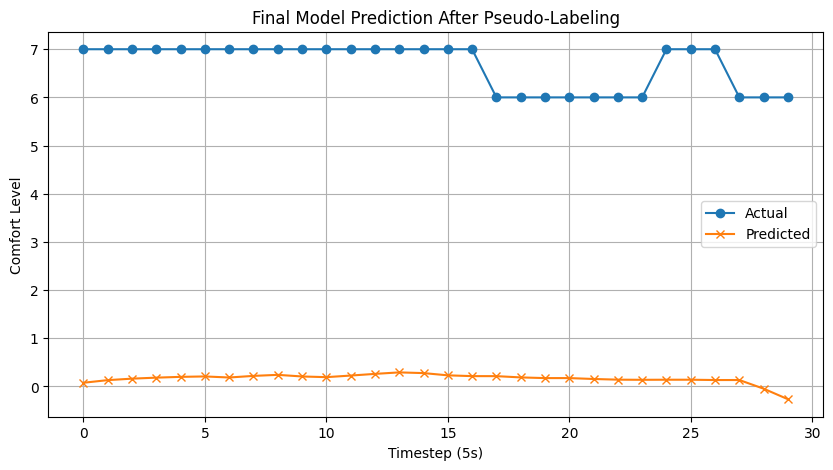

In [ ]:
# Use your untouched test set (from original real labeled data)
test_loss, test_mae = model_psu.evaluate(
    X_test, y_test,
    sample_weight=weights_test.squeeze(-1)
)
print(f"✅ Final Model Evaluation:\nTest MSE: {test_loss:.4f}\nTest MAE: {test_mae:.4f}")

y_pred_final = model_psu.predict(X_test_scaled)

# Pick an example session
example_idx = 0
valid_len = int(np.sum(weights_test[example_idx].squeeze() > 0))

plt.figure(figsize=(10, 5))
plt.plot(y_test[example_idx].squeeze()[:valid_len], label="Actual", marker='o')
plt.plot(y_pred_final[example_idx].squeeze()[:valid_len], label="Predicted", marker='x')
plt.title("Final Model Prediction After Pseudo-Labeling")
plt.xlabel("Timestep (5s)")
plt.ylabel("Comfort Level")
plt.grid(True)
plt.legend()
plt.show()


#### Testing v2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, MaxPooling1D, GRU, Dropout, TimeDistributed, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
enriched_dim = X_combined.shape[2]

# 2) Model builder
def build_model(hp):
    filters   = hp.Choice('filters',    [16, 32, 64])
    kernel    = hp.Choice('kernel',     [2, 3, 5])
    units1    = hp.Choice('gru1',       [32, 64, 128])
    units2    = hp.Choice('gru2',       [16, 32, 64])
    dropout1  = hp.Float('drop1',       0.1, 0.3, step=0.1)
    dropout2  = hp.Float('drop2',       0.05, 0.2, step=0.05)
    lr        = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    inp = Input(shape=(max_sequence_length, enriched_dim))
    x   = Masking(mask_value=0.0)(inp)
    x   = Conv1D(filters, kernel, padding='same', activation='relu')(x)
    x   = MaxPooling1D(2, strides=1, padding='same')(x)
    x   = GRU(units1, return_sequences=True, dropout=dropout1)(x)
    x   = GRU(units2, return_sequences=True, dropout=dropout2)(x)
    x   = TimeDistributed(Dense(16, activation='relu'))(x)
    out = TimeDistributed(Dense(1, activation='linear'))(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=directional_loss(lambda_delta=0.1),  # your custom transition‐aware loss
        metrics=['mae']
    )
    return model


# 3) Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cybersickness_tuning',
    overwrite=True
)

# 4) Run search
tuner.search(
    X_combined,
    y_combined,
    sample_weight=weights_combined.squeeze(-1),
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# 5) Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"  filters:       {best_hps.get('filters')}")
print(f"  kernel size:   {best_hps.get('kernel')}")
print(f"  GRU units1:    {best_hps.get('gru1')}")
print(f"  GRU units2:    {best_hps.get('gru2')}")
print(f"  dropout1:      {best_hps.get('drop1')}")
print(f"  dropout2:      {best_hps.get('drop2')}")
print(f"  learning rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 00m 14s]
val_mae: 0.07562536746263504

Best val_mae So Far: 0.027855264022946358
Total elapsed time: 00h 02m 32s
Best hyperparameters:
  filters:       16
  kernel size:   2
  GRU units1:    64
  GRU units2:    32
  dropout1:      0.2
  dropout2:      0.1
  learning rate: 0.0001


### 1D CNN Front-End + LSTM Back-End

In [ ]:

from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Masking(mask_value=0.0, input_shape=(max_sequence_length, num_features)),

    # 1D CNN Front-End
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2,strides=1, padding='same'),

    # LSTM Back-End for sequence modeling
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),

    # TimeDistributed Dense layers
    TimeDistributed(Dense(16, activation='relu')),
    TimeDistributed(Dense(1, activation='linear'))
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model_lstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_7' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_10 (Masking)                 │ (None, 76, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 76, 32)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 76, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 76, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 76, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 76, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 76, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 76, 16)              │             528 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 76, 1)               │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,305 (149.63 KB)

 Trainable params: 38,305 (149.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# Split session-wise (each session is one sample)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_padded, y_padded, sample_weights, test_size=0.2, random_state=42
)

history = model_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    sample_weight=weights_train.squeeze(-1)  # sample_weight shape should match (num_samples, timesteps)
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - loss: 13.9404 - mae: 2.5623 - val_loss: 12.7012 - val_mae: 2.6468
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step - loss: 12.9389 - mae: 2.6067 - val_loss: 10.7996 - val_mae: 2.5145
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - loss: 10.2051 - mae: 2.3653 - val_loss: 8.6582 - val_mae: 2.3419
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step - loss: 8.7601 - mae: 2.3136 - val_loss: 6.8650 - val_mae: 2.2299
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 623ms/step - loss: 6.8036 - mae: 2.1737 - val_loss: 5.4949 - val_mae: 2.1548
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - loss: 6.2073 - mae: 2.3075 - val_loss: 4.4023 - val_mae: 2.1184
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - loss: 4.6744 - mae: 2.1878 - val_loss: 3.5765 - val_mae: 2.0982
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - loss: 3.9477 - mae: 2.2187 - val_loss: 2.9584 - val_mae: 2.1116
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - loss: 3.3237 - mae

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 2.1478 - mae: 2.1911
Test MSE: 2.1477861404418945
Test MAE: 2.1910576820373535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


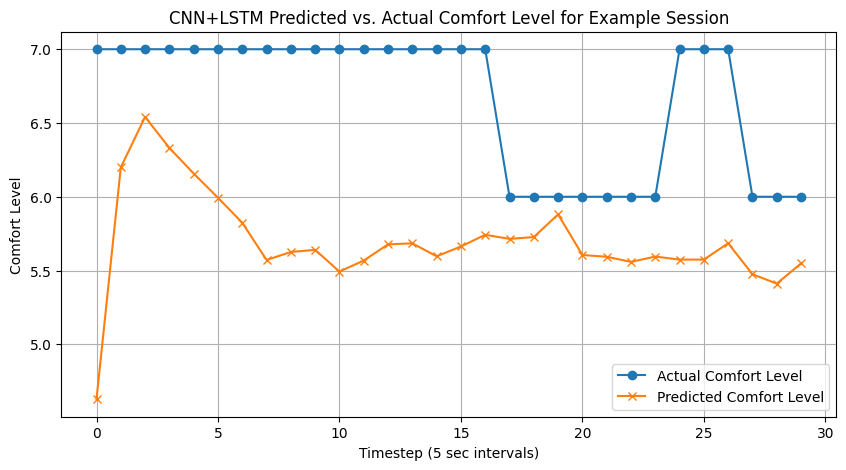

In [ ]:
loss, mae = model_lstm.evaluate(X_test, y_test, sample_weight=weights_test.squeeze(-1))
print("Test MSE:", loss)
print("Test MAE:", mae)

# Predict on the test set
y_pred = model_lstm.predict(X_test)

# Visualize predictions for one example session from the test set.
import matplotlib.pyplot as plt

# Choose an example session (e.g., first one)
example_idx = 0
# Determine the actual length of the session from weights: non-zero entries indicate real timesteps.
real_length = np.sum(weights_test[example_idx].squeeze() > 0)

# Extract the actual and predicted values for real timesteps only.
y_true_example = y_test[example_idx].squeeze()[:int(real_length)]
y_pred_example = y_pred[example_idx].squeeze()[:int(real_length)]

plt.figure(figsize=(10, 5))
plt.plot(y_true_example, label="Actual Comfort Level", marker='o')
plt.plot(y_pred_example, label="Predicted Comfort Level", marker='x')
plt.xlabel("Timestep (5 sec intervals)")
plt.ylabel("Comfort Level")
plt.title("CNN+LSTM Predicted vs. Actual Comfort Level for Example Session")
plt.legend()
plt.grid(True)
plt.show()


## Pure GRU

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Assume these are defined from your data preparation step:
# X_padded: shape (num_sessions, max_sequence_length, num_features)
# y_padded: shape (num_sessions, max_sequence_length, 1)
# For example:
#   num_features = 5  (['y_cordinate', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_cordinate'])
#   max_sequence_length = 76  (or whatever your padded length is)
#   y_padded contains the comfortLevel values, with padded timesteps set to 0.

# Define the Pure GRU model
model_pure_gru = Sequential([
    # Masking layer to ignore padded inputs (assumes padding value is 0.0)
    Masking(mask_value=0.0, input_shape=(X_padded.shape[1], X_padded.shape[2])),

    # GRU layers for sequence modeling
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32, return_sequences=True),
    Dropout(0.2),

    # TimeDistributed Dense layers to output prediction at each timestep
    TimeDistributed(Dense(16, activation='relu')),
    TimeDistributed(Dense(1, activation='linear'))  # Linear activation for regression
])

# Compile the model with a regression loss (MSE) and a metric (MAE)
model_pure_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model_pure_gru.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_13 (Masking)                 │ (None, 76, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 76, 64)              │          13,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 76, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 76, 32)              │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 76, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 76, 16)              │             528 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 76, 1)               │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,585 (92.13 KB)

 Trainable params: 23,585 (92.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data session-wise
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_padded, y_padded, sample_weights, test_size=0.2, random_state=42
)

history = model_pure_gru.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    sample_weight=weights_train.squeeze(-1)  # sample_weight shape should be (num_samples, timesteps)
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - loss: 32.8508 - mae: 2.9046 - val_loss: 25.7824 - val_mae: 2.7574
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - loss: 28.2731 - mae: 2.7601 - val_loss: 19.6998 - val_mae: 2.3686
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - loss: 21.5939 - mae: 2.2826 - val_loss: 13.9150 - val_mae: 1.9520
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - loss: 15.8948 - mae: 2.0487 - val_loss: 9.7557 - val_mae: 1.6151
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - loss: 11.1563 - mae: 1.6993 - val_loss: 6.9674 - val_mae: 1.3578
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - loss: 8.2962 - mae: 1.3244 - val_loss: 5.0921 - val_mae: 1.1350
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - loss: 5.4728 - mae: 1.0878 - val_loss: 4.1033 - val_mae: 1.0116
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - loss: 4.6543 - mae: 0.9913 - val_loss: 3.6852 - val_mae: 0.9479
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - loss: 3.9704 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 3.9050 - mae: 0.9630
Test MSE: 3.905043601989746
Test MAE: 0.9630489349365234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


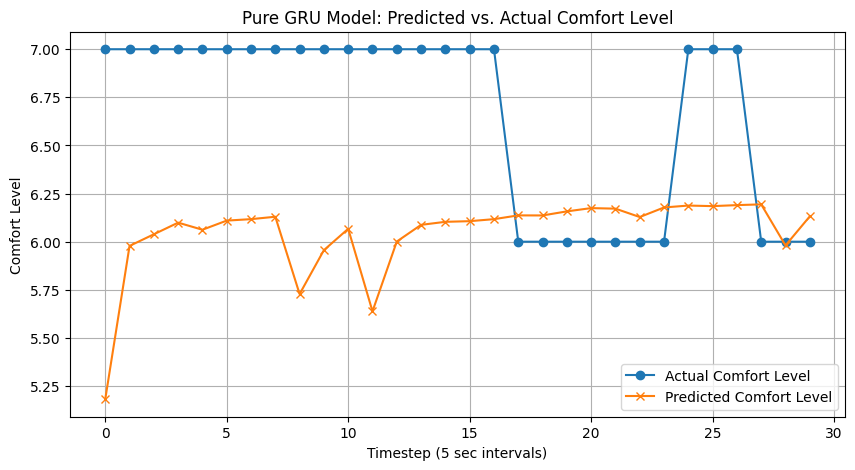

In [ ]:
loss, mae = model_pure_gru.evaluate(X_test, y_test, sample_weight=weights_test.squeeze(-1))
print("Test MSE:", loss)
print("Test MAE:", mae)

import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model_gru.predict(X_test)

# Choose an example session from the test set
example_idx = 0
# Determine the actual length of the session from weights (non-zero entries indicate real data)
real_length = int((weights_test[example_idx].squeeze() > 0).sum())

# Extract only the real timesteps for plotting
y_true_example = y_test[example_idx].squeeze()[:real_length]
y_pred_example = y_pred[example_idx].squeeze()[:real_length]

plt.figure(figsize=(10, 5))
plt.plot(y_true_example, label="Actual Comfort Level", marker='o')
plt.plot(y_pred_example, label="Predicted Comfort Level", marker='x')
plt.xlabel("Timestep (5 sec intervals)")
plt.ylabel("Comfort Level")
plt.title("Pure GRU Model: Predicted vs. Actual Comfort Level")
plt.legend()
plt.grid(True)
plt.show()


## Testing

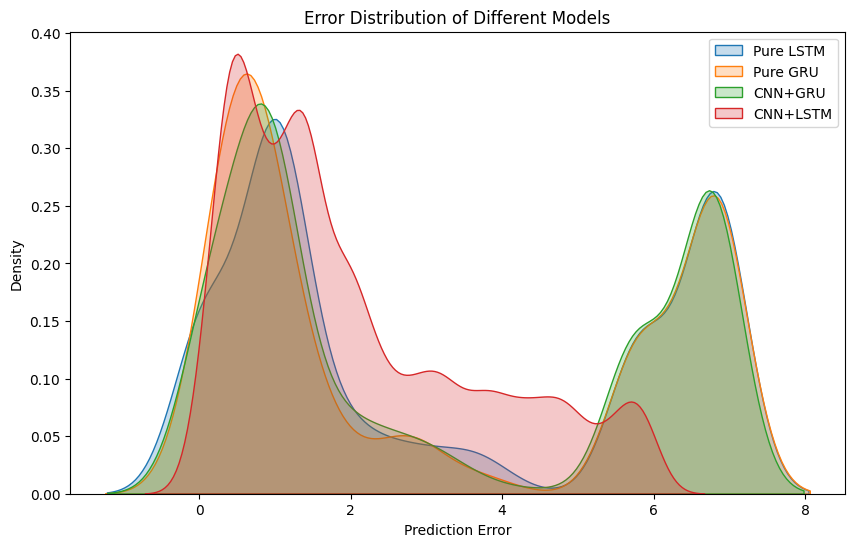

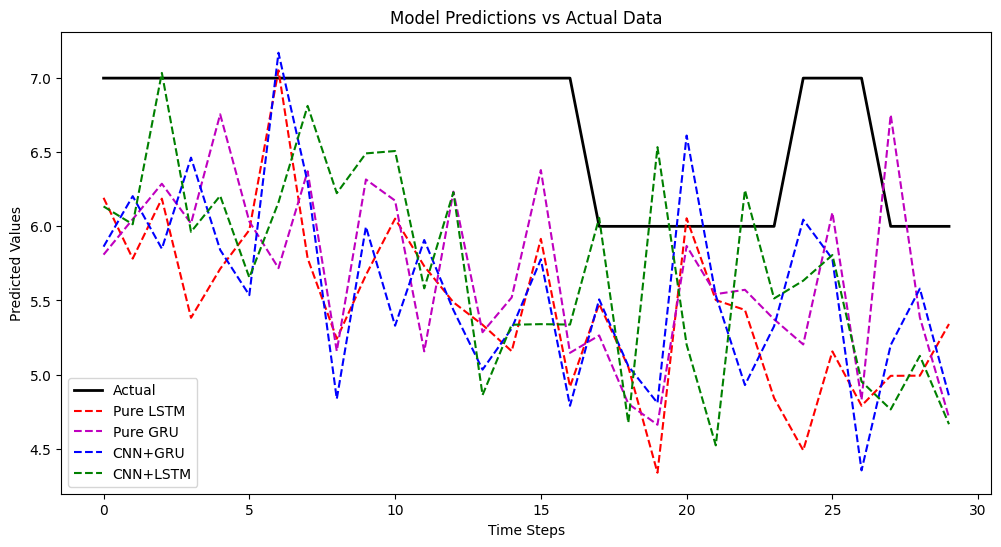

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Fix KDE plot warning ---
plt.figure(figsize=(10,6))
sns.kdeplot(error_pure_lstm.flatten(), label="Pure LSTM", fill=True)
sns.kdeplot(error_pure_gru.flatten(), label="Pure GRU", fill=True)
sns.kdeplot(error_cnn_gru.flatten(), label="CNN+GRU", fill=True)
sns.kdeplot(error_cnn_lstm.flatten(), label="CNN+LSTM", fill=True)

plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.title("Error Distribution of Different Models")
plt.legend()
plt.show()

# --- Fix time series plot ---
plt.figure(figsize=(12, 6))

# Ensure y_true_example and y_pred have the same length as timesteps
T = min(len(y_true_example), len(y_pred_example_pure_lstm))  # Adjust T dynamically
timesteps = np.arange(T)

plt.plot(timesteps, y_true_example[:T], 'k-', label="Actual", linewidth=2)
plt.plot(timesteps, y_pred_example_pure_lstm[:T], 'r--', label="Pure LSTM")
plt.plot(timesteps, y_pred_example_pure_gru[:T], 'm--', label="Pure GRU")
plt.plot(timesteps, y_pred_example_cnn_gru[:T], 'b--', label="CNN+GRU")
plt.plot(timesteps, y_pred_example_cnn_lstm[:T], 'g--', label="CNN+LSTM")

plt.xlabel("Time Steps")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs Actual Data")
plt.legend()
plt.show()


## MLP

In [ ]:

# Load and preprocess your data
df = pd.read_csv("DATA_score&eye.csv")


# Select 5 features (adjust to your use case)
features = ['y_cordinate', 'blink_count', 'avg_Left_Pupil', 'fixation_count', 'x_cordinate']
target = 'comfortLevel'

X = df[features]
y = df[target]

# Optional: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the model with 5-8-8-1 structure
model = Sequential([
    Dense(8, input_dim=5, activation='relu'),  # 1st hidden layer
    Dense(8, activation='relu'),               # 2nd hidden layer
    Dense(1, activation='linear')              # Output layer (regression)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=8, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print("Test MSE:", loss)
print("Test MAE:", mae)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 27.2961 - mae: 4.9176 - val_loss: 19.7976 - val_mae: 4.0540
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.0455 - mae: 3.6793 - val_loss: 11.9952 - val_mae: 2.5889
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4807 - mae: 2.2161 - val_loss: 9.1282 - val_mae: 1.8046
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0536 - mae: 1.7128 - val_loss: 7.0398 - val_mae: 1.6285
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7613 - mae: 1.5790 - val_loss: 5.4598 - val_mae: 1.5685
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7287 - mae: 1.5417 - val_loss: 4.7396 - val_mae: 1.5146
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3228 - mae: 1.4647 - val_loss: 4.0129 - val_mae: 1.4754
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1727 - mae: 1.4135 - val_loss: 3.5986 - val_mae: 1.4362
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


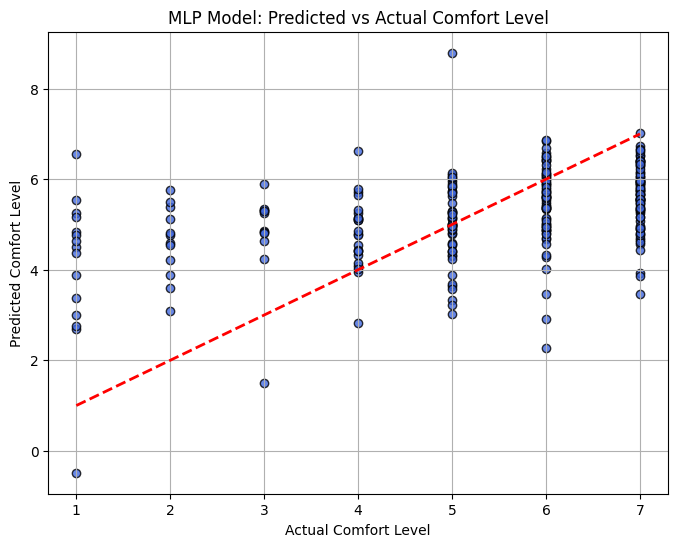

In [ ]:
import matplotlib.pyplot as plt

# Predict comfort levels using the test data
y_pred = model.predict(X_test)

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.8, color='royalblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Comfort Level")
plt.ylabel("Predicted Comfort Level")
plt.title("MLP Model: Predicted vs Actual Comfort Level")
plt.grid(True)
plt.show()


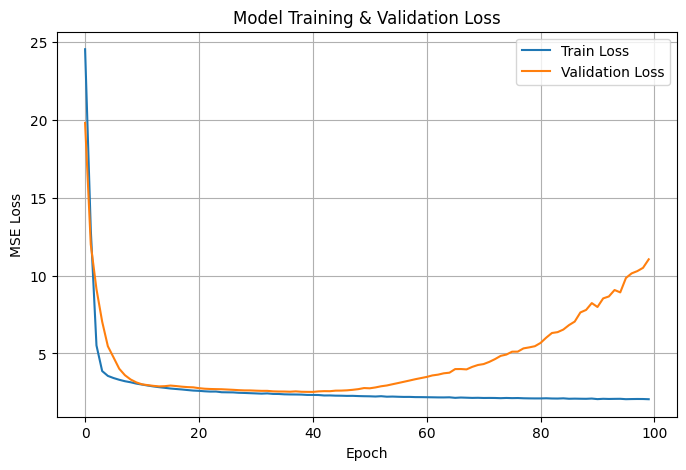

In [ ]:
# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Model Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("mlp_cybersickness_model.h5")


## Closed-Loop Feedback System wiht Unity Integration (C#)

Closed-feedback Loop system for manipulating the Fovated Rendering and Depth of Field bluring based on the RL

### Unity integration

In [ ]:
// CybersicknessPredictor.cs
using UnityEngine;
using Unity.Barracuda;

public class CybersicknessPredictor : MonoBehaviour
{
    public NNModel onnxModelAsset; // Assign your ONNX model in the Inspector.
    private Model runtimeModel;
    private IWorker worker;

    void Start()
    {
        // Load the ONNX model and create a worker for inference
        runtimeModel = ModelLoader.Load(onnxModelAsset);
        worker = WorkerFactory.CreateWorker(WorkerFactory.Type.ComputePrecompiled, runtimeModel);
    }

    /// <summary>
    /// Predicts cybersickness based on input features.
    /// </summary>
    /// <param name="fixationCount">Number of fixations</param>
    /// <param name="avgFixationDuration">Average duration of fixations</param>
    /// <param name="gazeVariance">Variance in gaze positions</param>
    /// <returns>Predicted cybersickness score (0-10 scale)</returns>
    public float PredictCybersickness(float fixationCount, float avgFixationDuration, float gazeVariance)
    {
        // Create a tensor with the input features.
        Tensor inputTensor = new Tensor(1, 3);
        inputTensor[0] = fixationCount;
        inputTensor[1] = avgFixationDuration;
        inputTensor[2] = gazeVariance;

        // Execute the model and get the output
        worker.Execute(inputTensor);
        Tensor output = worker.PeekOutput();
        float cybersicknessScore = output[0];

        // Dispose tensors to free up resources
        inputTensor.Dispose();
        output.Dispose();

        return cybersicknessScore;
    }

    void OnDestroy()
    {
        worker.Dispose();
    }
}


Explanation:

• This script loads the ONNX model using Barracuda, sets up an inference worker, and defines a method to take three input features and output a cybersickness prediction.

• You’ll need to ensure the feature order and dimensions match what you defined during training.

### Closed-loop controler

In [ ]:
// VRAdaptiveController.cs
using UnityEngine;

public class VRAdaptiveController : MonoBehaviour
{
    public CybersicknessPredictor predictor; // Reference to the predictor script.
    public float thresholdHigh = 7.0f;
    public float thresholdLow = 3.0f;

    // References to modules that control VR rendering parameters.
    public FoveatedRenderingController foveatedController;
    public DepthOfFieldController depthController;
    // (Optional) Additional module for Field of View adjustments

    void Update()
    {
        // Retrieve eye tracking data from your VR SDK.
        // Replace these dummy methods with actual API calls.
        float fixationCount = GetFixationCount();
        float avgFixationDuration = GetAverageFixationDuration();
        float gazeVariance = GetGazeVariance();

        // Get the cybersickness score using the ML model.
        float cybersicknessScore = predictor.PredictCybersickness(fixationCount, avgFixationDuration, gazeVariance);
        Debug.Log("Cybersickness Score: " + cybersicknessScore);

        // Adaptive control logic:
        if (cybersicknessScore > thresholdHigh)
        {
            // If the score is high, increase mitigation efforts.
            foveatedController.IncreaseFFR();
            depthController.AdjustDOFForComfort();
            // Optionally: adjust FOV if implemented.
        }
        else if (cybersicknessScore < thresholdLow)
        {
            // If the score is low, relax the adjustments.
            foveatedController.DecreaseFFR();
            depthController.ResetDOF();
        }
        // Otherwise, maintain current settings.
    }

    // Dummy methods – replace with your VR API methods to extract eye tracking data.
    float GetFixationCount()
    {
        // TODO: Replace with actual data from your VR headset's eye tracking.
        return 5.0f;
    }

    float GetAverageFixationDuration()
    {
        return 0.2f;
    }

    float GetGazeVariance()
    {
        return 0.05f;
    }
}


Explanation:

• This controller script gathers eye tracking data (you will replace the dummy methods with actual API calls from your VR SDK), calls the prediction model, and then uses simple threshold-based logic to decide if adjustments should be made.

### Foveated Rendering Controller Script

In [ ]:
// FoveatedRenderingController.cs
using UnityEngine;

public class FoveatedRenderingController : MonoBehaviour
{
    public float ffrStrength = 0.5f; // Base FFR strength.

    public void IncreaseFFR()
    {
        ffrStrength = Mathf.Min(ffrStrength + 0.1f, 1.0f);
        ApplyFFRSettings();
    }

    public void DecreaseFFR()
    {
        ffrStrength = Mathf.Max(ffrStrength - 0.1f, 0.0f);
        ApplyFFRSettings();
    }

    private void ApplyFFRSettings()
    {
        // Implement the call to your VR system’s FFR settings.
        // For example, if your VR SDK allows adjusting resolution in peripheral areas:
        Debug.Log("Applying FFR Strength: " + ffrStrength);
        // TODO: Integrate with actual rendering settings.
    }
}


Explanation:

• This script defines methods to increase or decrease the strength of the foveated rendering effect. Adjust the internal logic to suit your VR system’s API.

### Depth of Field Controller Script

In [ ]:
// DepthOfFieldController.cs
using UnityEngine;

public class DepthOfFieldController : MonoBehaviour
{
    public float currentDOFIntensity = 0.5f;

    public void AdjustDOFForComfort()
    {
        // Increase DOF intensity (or adjust parameters) to reduce peripheral distractions.
        currentDOFIntensity = Mathf.Min(currentDOFIntensity + 0.1f, 1.0f);
        ApplyDOFSettings();
    }

    public void ResetDOF()
    {
        // Reset DOF settings to a default comfortable value.
        currentDOFIntensity = 0.5f;
        ApplyDOFSettings();
    }

    private void ApplyDOFSettings()
    {
        // Apply the DOF adjustments to your camera's post-processing profile.
        Debug.Log("DOF intensity set to " + currentDOFIntensity);
        // TODO: Link with your post-processing stack or DOF effect settings.
    }
}


Explanation:

• This script similarly adjusts the intensity of a Depth of Field effect based on the cybersickness prediction. Customize the effect parameters based on your VR scene’s needs.

In [ ]:
#exmple integration code

using UnityEngine;
using UnityEngine.UI;

public class AdaptiveFOVController : MonoBehaviour
{
    public Camera targetCamera;           // The camera whose FOV will be adjusted.
    public Text fovDisplayText;           // UI Text to display the current FOV.
    public float fovAdjustmentRate = 1f;  // How fast the FOV changes per update.
    public float thresholdHigh = 7.0f;    // Score threshold indicating high cybersickness.
    public float thresholdLow = 3.0f;     // Score threshold indicating low cybersickness.
    public float minFOV = 30f;
    public float maxFOV = 120f;

    // Simulated ML model component. In a real integration, this could be your Barracuda inference script.
    // For example, you might have a CybersicknessPredictor component with a method:
    // public float PredictCybersickness();
    // Here, we simulate it with a dummy function.
    public float GetPredictedCybersickness()
    {
        // Replace this with your actual ML inference call.
        // For example, return your ML model's prediction based on current sensor data.
        return Random.Range(0f, 10f);
    }

    void Update()
    {
        // Get the predicted cybersickness score from your ML model.
        float predictedScore = GetPredictedCybersickness();

        // Use the score to determine FOV adjustments.
        // For example: If cybersickness is high, decrease FOV to reduce peripheral stimulation.
        if (predictedScore > thresholdHigh && targetCamera.fieldOfView > minFOV)
        {
            targetCamera.fieldOfView = Mathf.Max(targetCamera.fieldOfView - fovAdjustmentRate * Time.deltaTime, minFOV);
        }
        else if (predictedScore < thresholdLow && targetCamera.fieldOfView < maxFOV)
        {
            targetCamera.fieldOfView = Mathf.Min(targetCamera.fieldOfView + fovAdjustmentRate * Time.deltaTime, maxFOV);
        }

        // Optionally update UI text to show the current FOV and predicted score.
        if (fovDisplayText != null)
        {
            fovDisplayText.text = $"FOV: {targetCamera.fieldOfView:F1}\nScore: {predictedScore:F1}";
        }
    }
}


## Finalization

In Unity:

* Import your ONNX model asset and add it to a GameObject with the CybersicknessPredictor component.

* Create separate GameObjects for the FoveatedRenderingController and DepthOfFieldController and attach their scripts.

* Attach the VRAdaptiveController script to a central controller GameObject and assign the above components in the Inspector.

Real-Time Operation:

* During runtime, the VRAdaptiveController will call your dummy eye tracking data methods (replace these with actual sensor calls).

* The predictor makes a continuous prediction which the controller uses to adjust rendering parameters via your adaptive controllers.

Testing & Iteration:

* Validate the prediction output and observe the dynamic adjustments.

* Use debugging logs to fine-tune threshold values, increment steps, and overall system responsiveness.
